In [51]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
tmp = pd.read_csv('Beehive Metrics Dataset/new_temp_2017.csv')
tmp.head()

,timestamp,min,max,mean
0,1/1/2017 5:00,-1.911244,4.505489,1.699496
1,1/1/2017 6:00,-3.370600,4.495117,1.092577
2,1/1/2017 7:00,-3.582800,4.276133,0.964174
3,1/1/2017 8:00,-3.881800,3.711483,0.824071
4,1/1/2017 9:00,-4.742200,3.108950,0.266976


In [3]:
hum = pd.read_csv('Beehive Metrics Dataset/humidity_2017.csv')
hum.head()

,timestamp,humidity
0,2017-01-01 05:00:00,92.406667
1,2017-01-01 06:00:00,92.270000
2,2017-01-01 07:00:00,92.575000
3,2017-01-01 08:00:00,92.840000
4,2017-01-01 09:00:00,93.640000


In [4]:
flow = pd.read_csv('Beehive Metrics Dataset/new_flow_2017.csv')
flow.head()

,timestamp,out,in
0,1/1/2017 5:15,0,0
1,1/1/2017 5:16,0,0
2,1/1/2017 5:17,0,0
3,1/1/2017 5:18,0,0
4,1/1/2017 5:19,0,0


In [5]:
weight = pd.read_csv('Beehive Metrics Dataset/weight_2017.csv')
weight.head()

,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973


In [6]:
#Change the timestamp fields to the datetime data type
tmp['timestamp'] = pd.to_datetime(tmp['timestamp'])
hum['timestamp'] = pd.to_datetime(hum['timestamp'])
flow['timestamp'] = pd.to_datetime(flow['timestamp'])
weight['timestamp'] = pd.to_datetime(weight['timestamp'])

In [7]:
#Check the datatypes
tmp.info()
hum.info()
flow.info()
weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104821 entries, 0 to 104820
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  104821 non-null  datetime64[ns]
 1   min        104821 non-null  float64       
 2   max        104821 non-null  float64       
 3   mean       104821 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8737 entries, 0 to 8736
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8737 non-null   datetime64[ns]
 1   humidity   8737 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 136.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524050 entries, 0 to 524049
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------

In [8]:
#Count blanks or whitespaces
tmp = tmp.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
#Is anything null?
tmp.isnull().sum()

timestamp    0
min          0
max          0
mean         0
dtype: int64

In [9]:
hum = hum.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
hum.isnull().sum()

timestamp    0
humidity     0
dtype: int64

In [10]:
flow = flow.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
flow.isnull().sum()

timestamp    0
out          0
in           0
dtype: int64

In [11]:
weight = weight.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
weight.isnull().sum()

timestamp    0
weight       0
dtype: int64

In [12]:
#Remove what we need to from hum
hum.drop([3006, 3007], inplace = True)

In [13]:
tmp.isnull().sum()

timestamp    0
min          0
max          0
mean         0
dtype: int64

In [14]:
#Merge humidity and temp together
tmpdf = hum.merge(tmp, how='left', on='timestamp')
tmpdf.head(20)

,timestamp,humidity,min,max,mean
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033


In [15]:
#Merge flow in
tmpdf2 = tmpdf.merge(flow, how='left', on='timestamp')
tmpdf2.head(20)

,timestamp,humidity,min,max,mean,out,in
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496,NaN,NaN
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577,0.0,0.0
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174,0.0,0.0
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071,0.0,0.0
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976,0.0,0.0
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223,0.0,0.0
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697,0.0,0.0
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183,0.0,0.0
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385,0.0,0.0
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033,0.0,0.0


In [16]:
#Merge weight in
df = tmpdf2.merge(weight, how='left', on='timestamp')
df.head(20)

,timestamp,humidity,min,max,mean,out,in,weight
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496,NaN,NaN,NaN
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577,0.0,0.0,52.6972
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174,0.0,0.0,52.6972
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071,0.0,0.0,52.6652
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976,0.0,0.0,52.6652
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223,0.0,0.0,52.4731
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697,0.0,0.0,52.4091
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183,0.0,0.0,52.5051
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385,0.0,0.0,52.6332
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033,0.0,0.0,52.6972


In [17]:
#Looks like we got some nulls in there somewhere along the line
df.isnull().sum()

timestamp    0
humidity     0
min          0
max          0
mean         0
out          1
in           1
weight       1
dtype: int64

In [18]:
df.dropna(inplace = True)

In [19]:
#Drop some outliers here
df.loc[df['out']<-300]

,timestamp,humidity,min,max,mean,out,in,weight
3077,2017-05-09 13:00:00,76.380167,15.214,34.5725,29.313923,-345.0,124.0,49.1124


In [20]:
df.loc[df['weight']<=25]

,timestamp,humidity,min,max,mean,out,in,weight
3145,2017-05-12 09:00:00,71.010167,16.630,35.345500,31.769282,-91.0,89.0,-0.115216
3146,2017-05-12 10:00:00,70.764000,16.276,35.349833,31.788718,-73.0,84.0,-0.115216
3147,2017-05-12 11:00:00,71.992833,16.560,35.297333,31.857808,-81.0,85.0,-0.115216
3148,2017-05-12 12:00:00,71.175500,17.946,35.305167,32.217308,-211.0,104.0,-0.115216
3220,2017-05-15 12:00:00,59.246167,21.342,35.277667,32.807269,-175.0,137.0,-0.115216
3221,2017-05-15 13:00:00,58.658833,21.826,35.202000,32.892346,-129.0,156.0,-0.115216
3222,2017-05-15 14:00:00,55.732167,22.286,35.140000,32.993038,-187.0,121.0,-0.115216
3223,2017-05-15 15:00:00,51.139833,23.356,35.012000,33.061744,-116.0,145.0,-0.115216
6243,2017-09-18 11:00:00,84.095833,12.098,16.619667,15.172346,-2.0,2.0,0.140845
6244,2017-09-18 12:00:00,58.307500,15.220,31.496500,24.697769,-3.0,1.0,-0.051201


In [21]:
df.drop(df.loc[df['weight']<=25].index, inplace = True)
df.drop(3077, inplace = True)

In [22]:
df.reset_index(drop = True, inplace=True)

In [23]:
#Let's see if limiting the time to the spring-summer changes anything
#df.drop(df.loc[df['timestamp']<"2017-04-01"].index, inplace = True)
#df.drop(df.loc[df['timestamp']>"2017-10-01"].index, inplace = True)

In [24]:
#Show off the temp changes
#df.plot(x='timestamp', y=['mean','min','max'])

In [25]:
def checkID(row):
    if row == 0:
        return True
    else:
        return False

In [42]:
#Creating the column for change in weight
df['weightchange'] = df.apply(lambda currRow: 0 if checkID(int(currRow.name)) else (currRow.weight - float(df.iloc[int(currRow.name) - 1, 7])), axis = 1)
#df.apply(lambda x: print(str(x.name) + " " + str(x.weight)), axis = 1)
df.drop(df.loc[df['weightchange']>=10].index, inplace = True)
df.drop(df.loc[df['weightchange']<=-10].index, inplace = True)
df

,timestamp,humidity,min,max,mean,out,in,weight,weightchange
0,2017-01-01 06:00:00,92.270000,-3.3706,4.495117,1.092577,0.0,0.0,52.6972,0.0000
1,2017-01-01 07:00:00,92.575000,-3.5828,4.276133,0.964174,0.0,0.0,52.6972,0.0000
2,2017-01-01 08:00:00,92.840000,-3.8818,3.711483,0.824071,0.0,0.0,52.6652,-0.0320
3,2017-01-01 09:00:00,93.640000,-4.7422,3.108950,0.266976,0.0,0.0,52.6652,0.0000
4,2017-01-01 10:00:00,93.768333,-4.7170,3.360517,0.107223,0.0,0.0,52.4731,-0.1921
...,...,...,...,...,...,...,...,...,...
8720,2017-12-31 01:00:00,90.255000,10.3460,19.169333,14.246423,0.0,0.0,53.6574,-0.0320
8721,2017-12-31 02:00:00,91.685000,9.9300,19.855500,14.212385,0.0,0.0,53.7214,0.0640
8722,2017-12-31 03:00:00,92.323333,9.8000,19.935333,14.322692,0.0,0.0,53.6574,-0.0640
8723,2017-12-31 04:00:00,92.675000,10.0100,19.812000,14.597641,0.0,0.0,53.6574,0.0000


<AxesSubplot:xlabel='timestamp'>

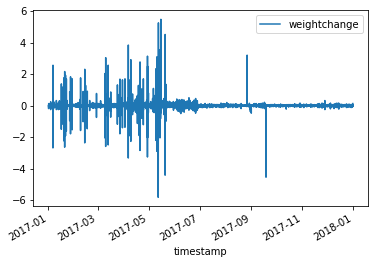

In [43]:
#Lets see the weight change graphed
df.plot(x="timestamp", y="weightchange")

In [28]:
#Calc St. Deviation
df.std()

timestamp       105 days 03:29:28.100258552
humidity                          15.468879
min                                8.459373
max                                9.924322
mean                               9.822811
out                               28.762815
in                                25.649498
weight                              5.85498
weightchange                       0.379776
dtype: object

In [29]:
#Values within the 50% quantile
df.quantile

<bound method DataFrame.quantile of                timestamp   humidity      min        max       mean  out   in  \
0    2017-01-01 06:00:00  92.270000  -3.3706   4.495117   1.092577  0.0  0.0   
1    2017-01-01 07:00:00  92.575000  -3.5828   4.276133   0.964174  0.0  0.0   
2    2017-01-01 08:00:00  92.840000  -3.8818   3.711483   0.824071  0.0  0.0   
3    2017-01-01 09:00:00  93.640000  -4.7422   3.108950   0.266976  0.0  0.0   
4    2017-01-01 10:00:00  93.768333  -4.7170   3.360517   0.107223  0.0  0.0   
...                  ...        ...      ...        ...        ...  ...  ...   
8720 2017-12-31 01:00:00  90.255000  10.3460  19.169333  14.246423  0.0  0.0   
8721 2017-12-31 02:00:00  91.685000   9.9300  19.855500  14.212385  0.0  0.0   
8722 2017-12-31 03:00:00  92.323333   9.8000  19.935333  14.322692  0.0  0.0   
8723 2017-12-31 04:00:00  92.675000  10.0100  19.812000  14.597641  0.0  0.0   
8724 2017-12-31 05:00:00  91.900000  10.9820  19.657333  14.765385 -1.0  0.0   

   

In [30]:
#We can finally do covariance too!
df.cov()

,humidity,min,max,mean,out,in,weight,weightchange
humidity,239.286231,-103.349085,-86.454352,-106.406174,243.914590,-218.432884,-75.016043,-0.135180
min,-103.349085,71.560996,66.015652,75.472170,-139.677705,127.292116,33.054849,0.086243
max,-86.454352,66.015652,98.492166,90.913341,-117.730071,105.190644,20.264332,0.062287
mean,-106.406174,75.472170,90.913341,96.487619,-148.254790,133.318167,30.788752,0.070533
out,243.914590,-139.677705,-117.730071,-148.254790,827.299529,-682.256726,-72.203848,0.028296
in,-218.432884,127.292116,105.190644,133.318167,-682.256726,657.896723,63.233187,0.325964
weight,-75.016043,33.054849,20.264332,30.788752,-72.203848,63.233187,34.280796,0.071769
weightchange,-0.135180,0.086243,0.062287,0.070533,0.028296,0.325964,0.071769,0.144230


In [31]:
#And correlation
df.corr()

,humidity,min,max,mean,out,in,weight,weightchange
humidity,1.000000,-0.789786,-0.563154,-0.700281,0.548211,-0.550529,-0.828266,-0.023010
min,-0.789786,1.000000,0.786335,0.908266,-0.574060,0.586657,0.667377,0.026845
max,-0.563154,0.786335,1.000000,0.932590,-0.412435,0.413235,0.348743,0.016526
mean,-0.700281,0.908266,0.932590,1.000000,-0.524737,0.529145,0.535341,0.018907
out,0.548211,-0.574060,-0.412435,-0.524737,1.000000,-0.924778,-0.428749,0.002590
in,-0.550529,0.586657,0.413235,0.529145,-0.924778,1.000000,0.421057,0.033463
weight,-0.828266,0.667377,0.348743,0.535341,-0.428749,0.421057,1.000000,0.032276
weightchange,-0.023010,0.026845,0.016526,0.018907,0.002590,0.033463,0.032276,1.000000


<AxesSubplot:>

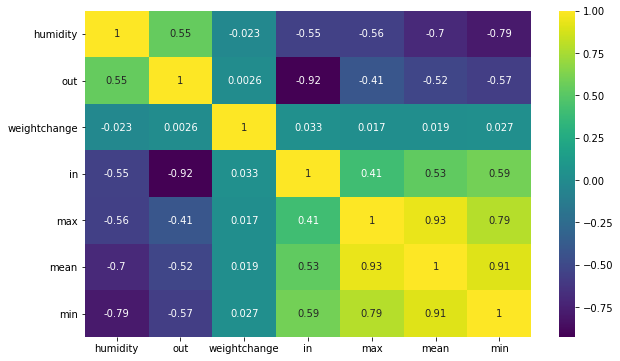

In [32]:
#Visualize correlation
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Heatmap')
    labels=['humidity', 'min', 'max', 'mean', 'out', 'in', 'weight', 'weightchange']
    ax1.set_xticklabels(labels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=10)
    fig.colorbar(cax, ticks=[-1,-.5,0,.5,1])
    plt.show()

#Quality correlation matrix
k = 7 #number of variables for heatmap
cols = df.corr().nlargest(k, 'humidity')['humidity'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [33]:
df2 = df[["humidity","min","max","mean","out","in", "weight", 'weightchange']]

In [34]:
ss = StandardScaler()
ss.fit_transform(df2)

array([[ 1.12036948e+00, -1.90702614e+00, -2.29519030e+00, ...,
        -5.13408224e-01, -5.66802905e-01, -3.28428330e-04],
       [ 1.14008762e+00, -1.93211218e+00, -2.31725689e+00, ...,
        -5.13408224e-01, -5.66802905e-01, -3.28428330e-04],
       [ 1.15721977e+00, -1.96745961e+00, -2.37415572e+00, ...,
        -5.13408224e-01, -5.72268650e-01, -8.45934437e-02],
       ...,
       [ 1.12381746e+00, -3.50013060e-01, -7.39305509e-01, ...,
        -5.13408224e-01, -4.02796373e-01, -1.68858459e-01],
       [ 1.14655258e+00, -3.25187103e-01, -7.51733602e-01, ...,
        -5.13408224e-01, -4.02796373e-01, -3.28428330e-04],
       [ 1.09644912e+00, -2.10278389e-01, -7.67319103e-01, ...,
        -5.13408224e-01, -3.80933391e-01,  3.36731633e-01]])

In [35]:
df2.head(20)

,humidity,min,max,mean,out,in,weight,weightchange
0,92.270000,-3.3706,4.495117,1.092577,0.0,0.0,52.6972,0.0000
1,92.575000,-3.5828,4.276133,0.964174,0.0,0.0,52.6972,0.0000
2,92.840000,-3.8818,3.711483,0.824071,0.0,0.0,52.6652,-0.0320
3,93.640000,-4.7422,3.108950,0.266976,0.0,0.0,52.6652,0.0000
4,93.768333,-4.7170,3.360517,0.107223,0.0,0.0,52.4731,-0.1921
5,92.950000,-3.4038,5.602583,0.618697,0.0,0.0,52.4091,-0.0640
6,92.080000,-2.7678,4.588617,0.892183,0.0,0.0,52.5051,0.0960
7,91.356667,-2.1272,4.864967,1.330385,0.0,0.0,52.6332,0.1281
8,91.071667,-1.6358,5.755283,1.723033,0.0,0.0,52.6972,0.0640
9,90.996667,-1.3362,6.023483,1.861309,0.0,0.0,52.7132,0.0160


In [36]:
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

c:\users\cjp99\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


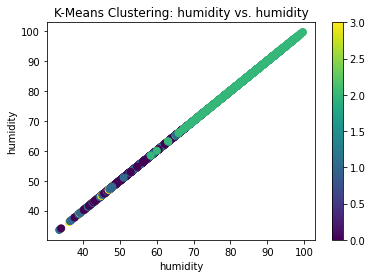

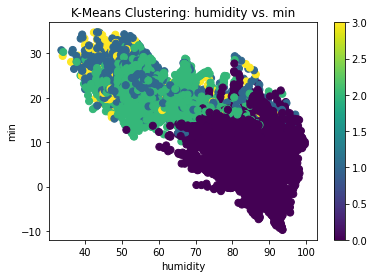

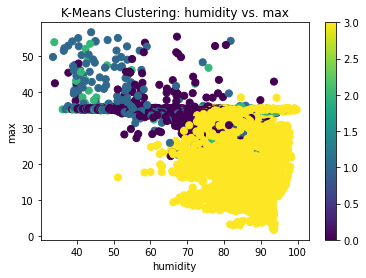

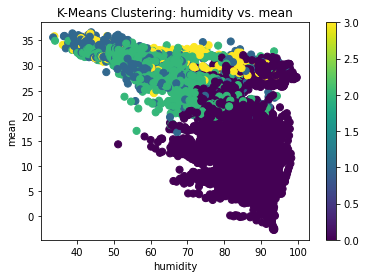

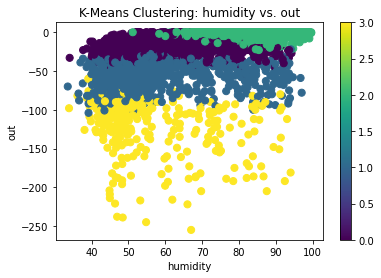

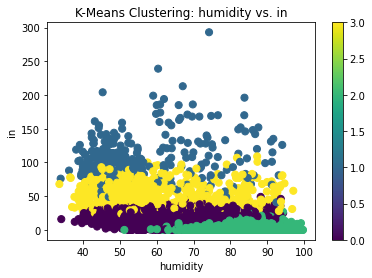

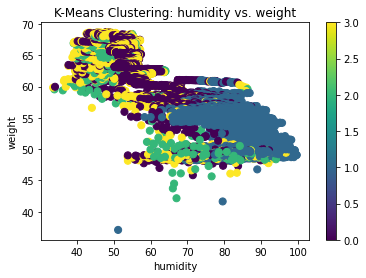

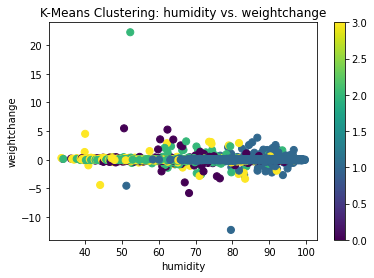

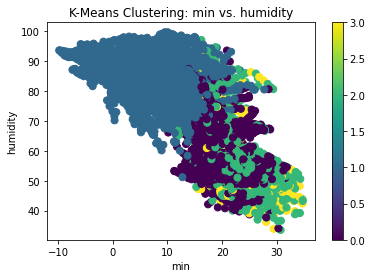

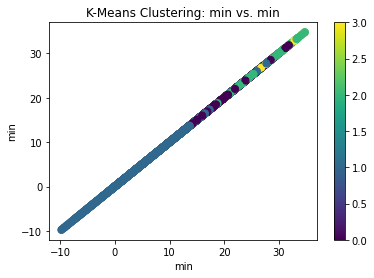

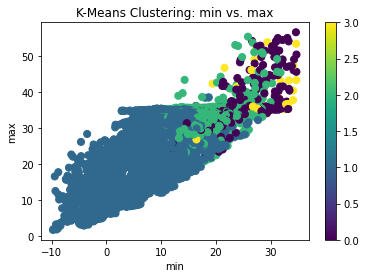

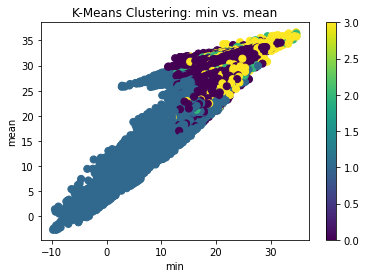

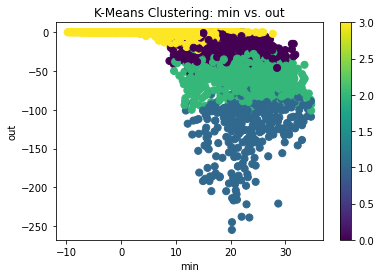

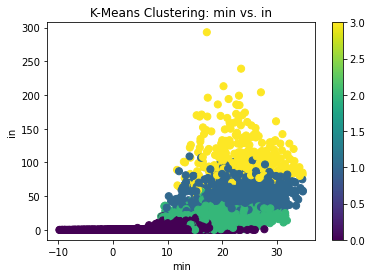

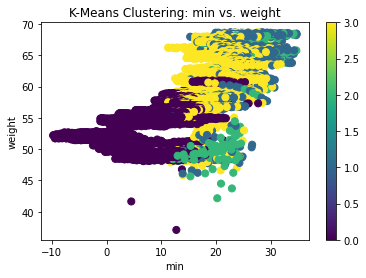

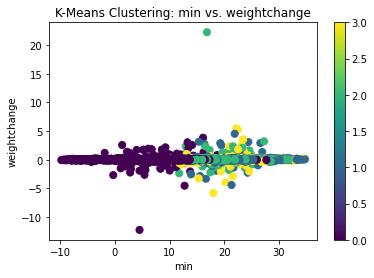

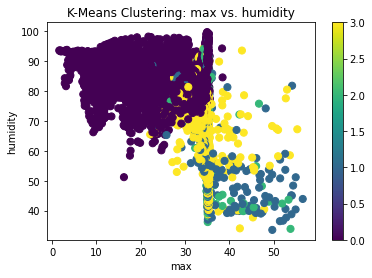

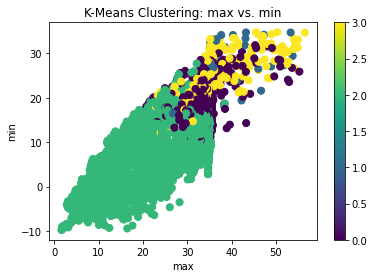

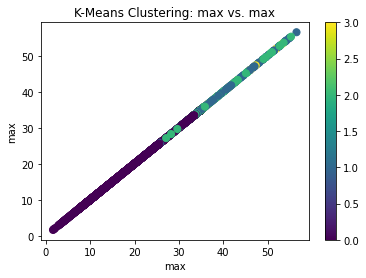

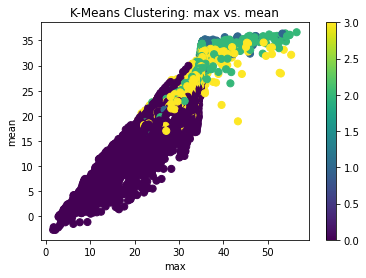

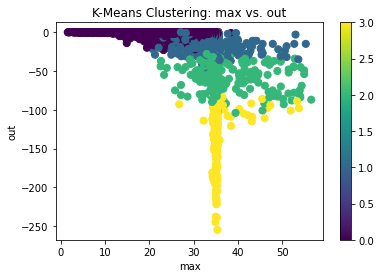

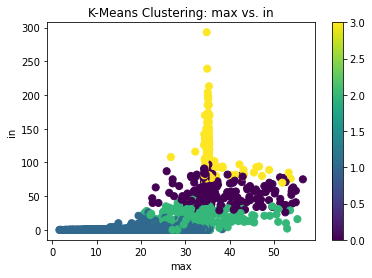

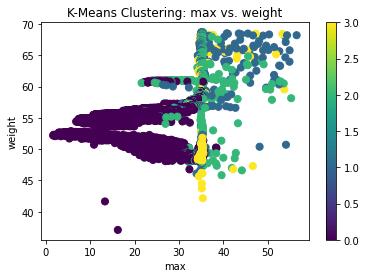

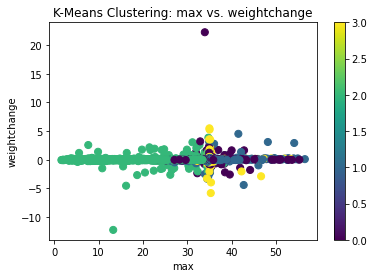

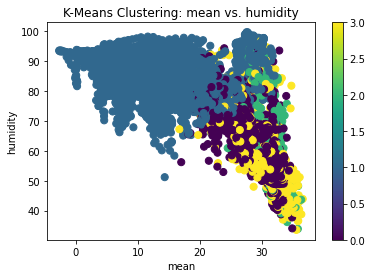

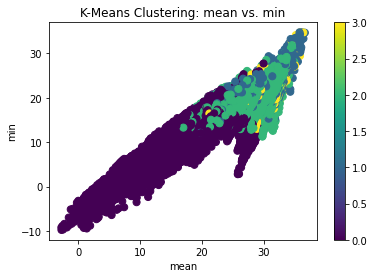

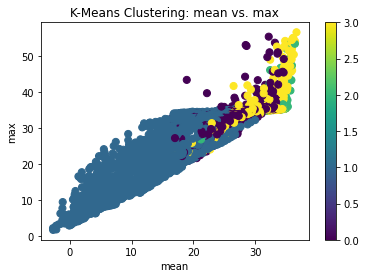

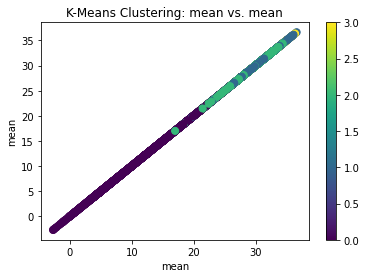

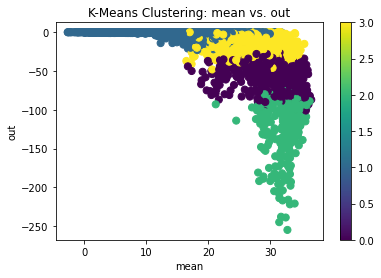

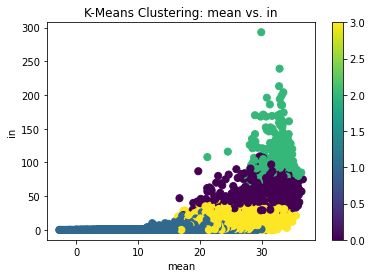

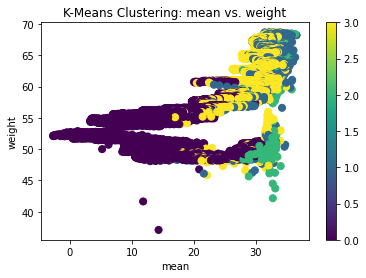

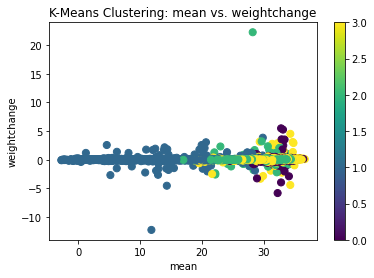

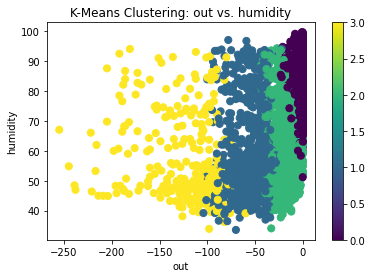

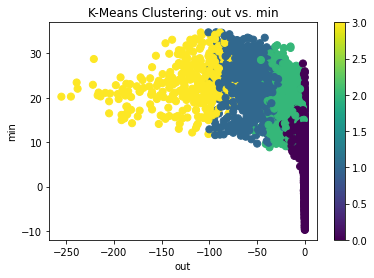

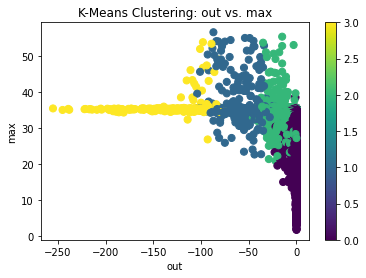

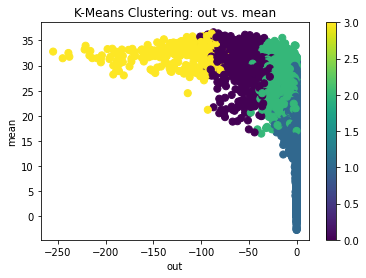

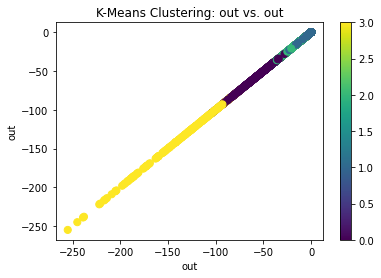

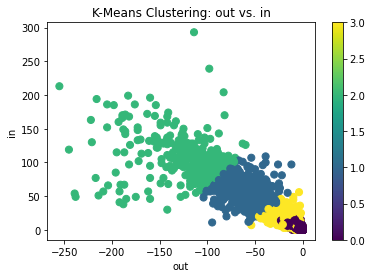

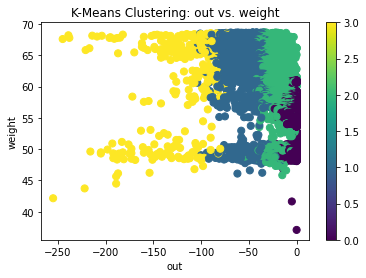

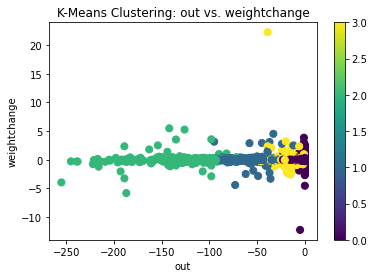

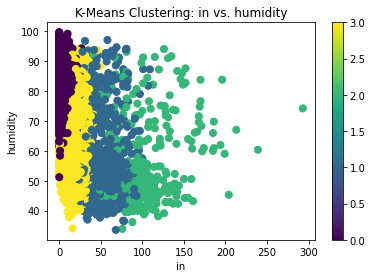

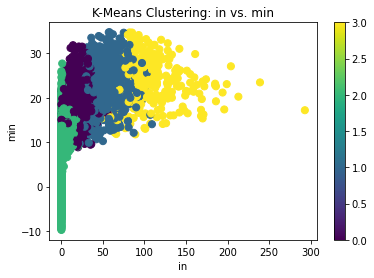

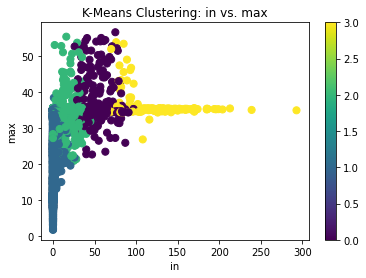

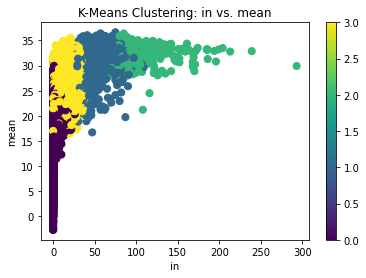

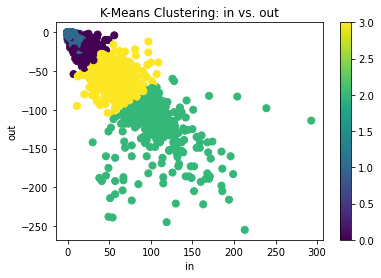

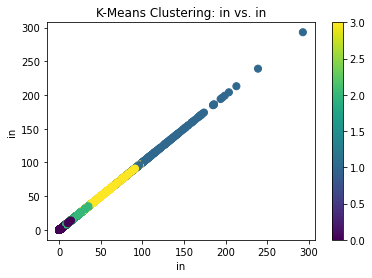

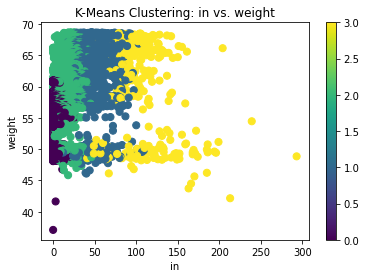

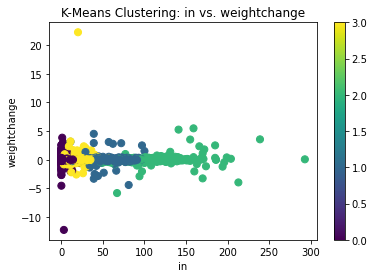

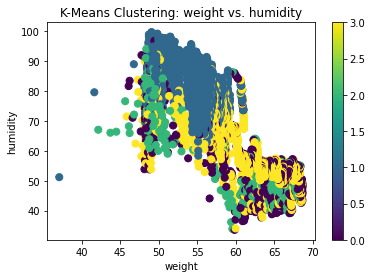

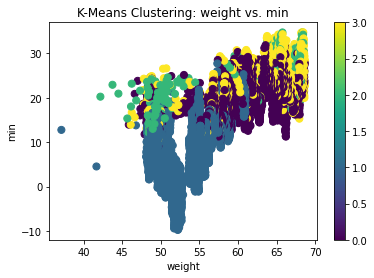

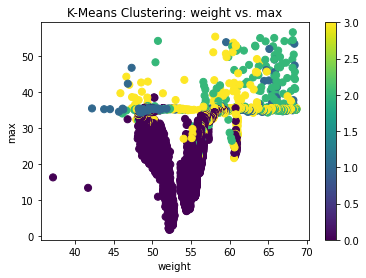

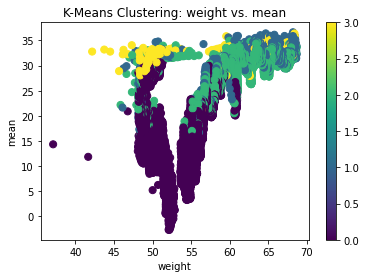

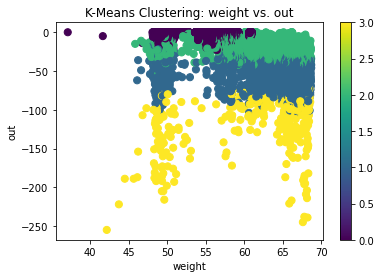

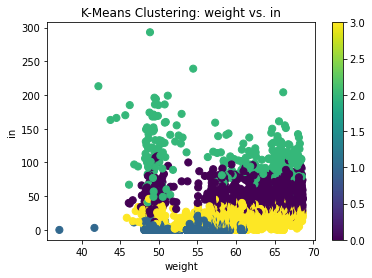

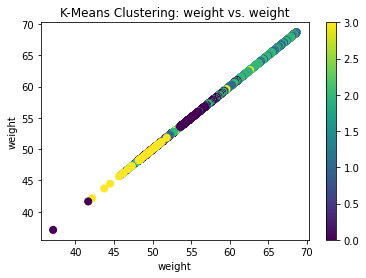

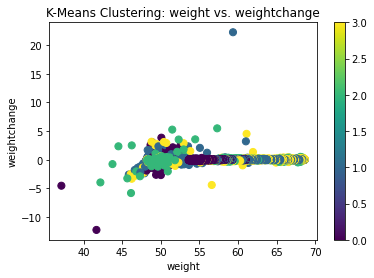

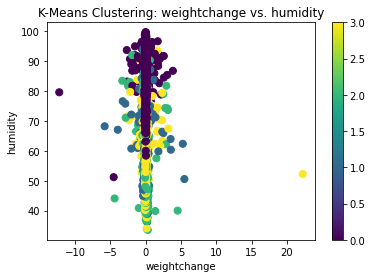

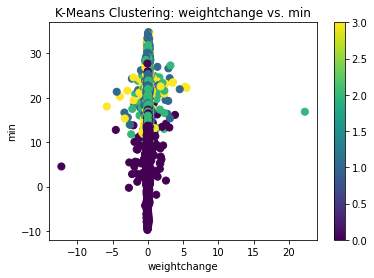

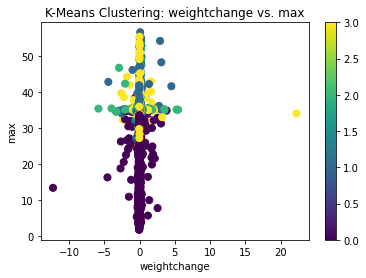

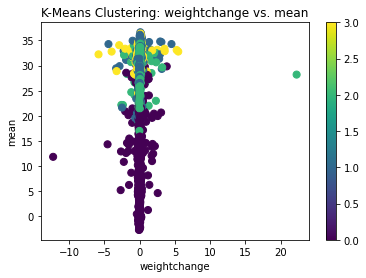

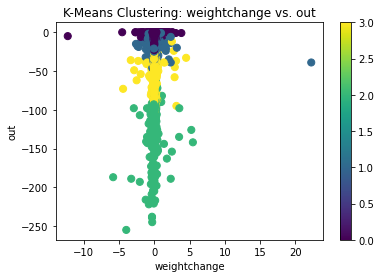

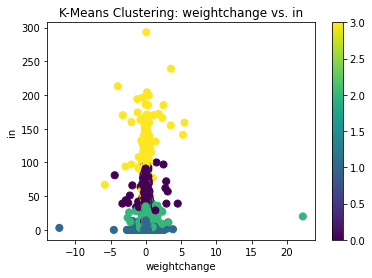

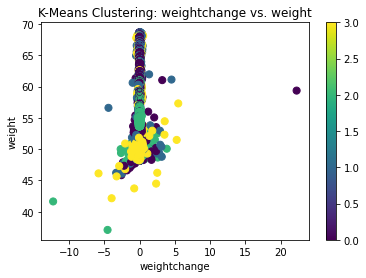

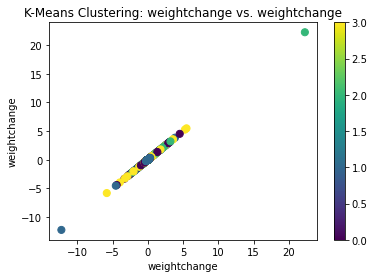

In [37]:
for col in df2:
    for col2 in df2:
        clust_labels, cent = doKmeans(df2, 4)
        kmeans = pd.DataFrame(clust_labels)
        #Plot the clusters obtained using k means
        fig = plt.figure()
        ax = fig.add_subplot(111)
        scatter = ax.scatter(df2[col],df2[col2],
                             c=kmeans[0],s=50)
        ax.set_title('K-Means Clustering: ' + col + " vs. " + col2)
        ax.set_xlabel(col)
        ax.set_ylabel(col2)
        plt.colorbar(scatter)

In [70]:
tmpdf = pd.DataFrame(df, columns=["humidity","min","max","mean","out","in", "weight", 'weightchange'])
for col in tmpdf.columns:
    print("Independent Variable: " + col)
    for col2 in tmpdf.columns:
        x = pd.DataFrame(tmpdf[col])
        y = pd.DataFrame(tmpdf[col2])
        reg = LinearRegression()
        reg.fit(x,y)
        print("Linear Regression between " + col + " and " + col2 + ": R2 score = " + str(reg.score(x,y)))
    print()

Independent Variable: humidity
Linear Regression between humidity and humidity: R2 score = 1.0
Linear Regression between humidity and min: R2 score = 0.6238262215110887
Linear Regression between humidity and max: R2 score = 0.3171302856160191
Linear Regression between humidity and mean: R2 score = 0.4903769591610295
Linear Regression between humidity and out: R2 score = 0.30047212003194046
Linear Regression between humidity and in: R2 score = 0.30310384014145564
Linear Regression between humidity and weight: R2 score = 0.6864014945402377
Linear Regression between humidity and weightchange: R2 score = 0.00029811452041594855

Independent Variable: min
Linear Regression between min and humidity: R2 score = 0.6238262215110888
Linear Regression between min and min: R2 score = 1.0
Linear Regression between min and max: R2 score = 0.61827405321272
Linear Regression between min and mean: R2 score = 0.8249295767301292
Linear Regression between min and out: R2 score = 0.32952439535673483
Linear 